In [1]:
import tensorflow as tf
from time import time
import numpy as np
import tensorflow.keras.backend as K
#import tensorflow_probability as tfp

from tensorflow.keras.layers import Layer, InputSpec,Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Conv1D,  Dense, Flatten, Reshape

from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from sklearn.cluster import KMeans

from datasets import load_mnist, load_usps, load_mrec

In [59]:
# load dataset
Ndataset='mrec'
Nclusters=4
Nsave_dir='temp'
Ngamma=0.1
Ntol=0.001
#num_batches = 100
batch_size = 256
learning_rate = 0.001
nGamma=0.1

xData, YY = load_mrec()
tdataset = tf.data.Dataset.from_tensor_slices((xData))
dataset = tdataset.batch(batch_size)

MM (4032, 258)
MREC: (4031, 8, 32, 1)


In [60]:
class Encoder(tf.keras.Model):
    def __init__(self,     input_shape=(8, 32, 1), filters=[32, 64, 128],aclusters=16):
        super(Encoder, self).__init__()
        #self.w='name'
        #self.ishape=input_shape
        self.filters=filters
        #self.pad3
        # model = Sequential()
        if input_shape[0] % 8 == 0:
            pad3 = 'same'
        else:
            pad3 = 'valid'
            
        self.conv0= Conv2D(self.filters[0], 5, strides=(1,2), padding='same', activation='relu', name='conv0', input_shape=input_shape)
        self.conv1= Conv2D(self.filters[1], 5, strides=(2,4), padding='same', activation='relu', name='conv1')
        self.conv2= Conv2D(self.filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv2')
        self.flat= Flatten()
        self.emb=Dense(units=aclusters, name='embedding')
         
               
    def call(self, x, training=True):
        #print('e0',x.shape)
        x = self.conv0(x)
        #print('e1',x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        #print('e3',x.shape)
        x = self.flat(x)
        return self.emb(x)
    
         
   

In [61]:
class Decoder(tf.keras.Model):
     def __init__(self,     output_shape=(8,32,1), filters=[32, 64, 128],aclusters=16):
        super(Decoder, self).__init__()
        if output_shape[0] % 8 == 0:
            pad3 = 'same'
        else:
            pad3 = 'valid'
        #self.ishape=input_shape
        self.filters=filters
      
        self.dense1=Dense(units=self.filters[2]*int(output_shape[0]/2)*int(output_shape[0]/8),input_shape=(aclusters,), activation='relu')

        self.resh1=Reshape((int(output_shape[0]/4), int(output_shape[1]/16), filters[2]))
        self.deconv2=Conv2DTranspose(self.filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv2')

        self.deconv1=Conv2DTranspose(self.filters[0], 3, strides=(2,4), padding='same', activation='relu', name='deconv1')
        self.deconv0=Conv2DTranspose(output_shape[2], 5, strides=(1,2), padding='same', name='deconv0')
    
     def call(self, x, training=True):
        #print('d0',x.shape)
        x = self.dense1(x)
        #print('d1',x.shape)
         
        x = self.resh1(x)
     
        x = self.deconv2(x)
        x = self.deconv1(x)
        x = self.deconv0(x)       
        return x 

In [62]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters,n_dim, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.n_dim=n_dim
        self.alpha = alpha
        self.initial_weights = weights
        #self.input_spec = InputSpec(ndim=2)
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, n_dim))
        self.clusters = self.add_weight('clusters',(self.n_clusters, self.n_dim),trainable=True, initializer='glorot_uniform')
 
      
        print('initLC')

 

    def build(self, input_shape):
        print('buildlc', input_shape)
        assert len(input_shape) == 2
        print('addw:',self.n_clusters)
        #self.clusters = self.add_weight('clusters',(self.n_clusters, self.n_dim),trainable=True, initializer='glorot_uniform')
        #input_dim = input_shape[1]
        #self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True
        super(ClusteringLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [63]:
class ClusteringModel(tf.keras.Model):
   
    def __init__(self,     aClusters=16,aDim=16):
        super(ClusteringModel, self).__init__()
        #self.w='name'
        self.emb=ClusteringLayer(n_clusters=aClusters,n_dim=aDim, name='clustering')
         
               
    def call(self, x, training=True):
        
        return self.emb(x)
    
    def setWeights(self,aWeights):
        self.emb.set_weights(aWeights)
 

In [64]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
#checkpoint = tf.train.Checkpoint(myModel=model,optimizer=optimizer)
g_encoder = Encoder(aclusters=Nclusters)
g_decoder = Decoder(aclusters=Nclusters)
         

In [65]:
def loss_mse( inputs, targets):
    #error = inputs - targets
    #sq=tf.square(error)
    sq=tf.keras.losses.MSE(inputs,targets)

    #return tf.compute_average_loss(   sq,        global_batch_size=GLOBAL_BATCH_SIZE)
    return tf.reduce_mean(sq)
def loss_kld(inputs,pred):
    _nn=tf.keras.losses.KLD( inputs,pred)
    return tf.reduce_mean(_nn)

In [66]:
def pre_train():
    #start = time.time()
    loss = 0
    xoptimizer = tf.optimizers.Adam()
    
    for (batch, (x)) in enumerate(dataset.take(-1)):
        #if batch % 10 == 0:
        #print('mse',x.shape)
                 
        #     print('.',end='')
        #    print('Batch {} loss{:.3f}'.format(batch,loss) )
    
        loss = 0
        with tf.GradientTape() as tape:
            g_encoder.trainable = True
            g_decoder.trainable = True
            z = g_encoder(x, training=True)
            x_hat = g_decoder(z, training=True)
            loss = loss_mse(x, x_hat)
            #print('mse',x.shape, loss.numpy())
                  
        #for  v in variables:
        #    print ("batch: ", v.name,'  ',v.shape)
        #print('nam:',g_encoder.trainable_variables.shape)
        #print('var:',variables)
        variables = g_encoder.trainable_variables + g_decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        
        xoptimizer.apply_gradients(zip(gradients, variables))
        #xoptimizer.minimize(loss,variables)
    return loss

In [67]:
EPOCHS = 6

for epoch in range(EPOCHS):
    ls=pre_train()
    print('Epoch {}  Loss {:.4f}'.format(epoch + 1,ls.numpy()))
    nn=g_encoder.predict(xData)
    nnp=nn.argmax(1)
    
    #printMetrics('pre: ',nnp,ls)
  

Epoch 1  Loss 0.1283
Epoch 2  Loss 0.0559
Epoch 3  Loss 0.0523
Epoch 4  Loss 0.0468
Epoch 5  Loss 0.0464
Epoch 6  Loss 0.0479


In [68]:
print('Initializing cluster centers with k-means.')
kmeans = KMeans(n_clusters=Nclusters, n_init=20)
y_pr = kmeans.fit_predict(g_encoder.predict(xData))
print('data',xData.shape)
print('pred:',y_pr.shape)
print(kmeans.cluster_centers_.shape)

Initializing cluster centers with k-means.
data (4031, 8, 32, 1)
pred: (4031,)
(4, 4)


In [69]:
g_clustering=ClusteringModel(Nclusters,Nclusters)
g_clustering.setWeights([kmeans.cluster_centers_])

initLC


In [70]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T


In [76]:
def cluster_train():
    nn2=g_encoder.predict(xData)
    nn=g_clustering.predict(nn2)
    #nnp=nn.argmax(1)
    
    p = target_distribution(nn)  # update the auxiliary target distribution p
    ndataset = tf.data.Dataset.from_tensor_slices((xData, p)).batch(batch_size)
    #printMetrics('Iter ',nnp,0.1)
    #print('x',xData[0])
    #print('q',nn[0])
    #print('p',p.shape, p[0])
    loss = 0
    variables = g_encoder.variables + g_decoder.variables+ g_clustering.variables
    #variables = g_encoder.variables + g_decoder.variables+ CLmodel.variables
         
    for (batch, (x, labels)) in enumerate(ndataset.take(-1)):
        #if batch % 10 == 0:
        #    nn=g_encoder.predict(xData)
    
            #p = target_distribution(nn)  # update the auxiliary target distribution p
            #yn=CLmodel(nn)
            #_nn=tf.keras.losses.KLD( p,yn)
            #print('nn',_nn)
        #     print('.',end='')
        #    print('Batch {} loss{:.3f}'.format(batch,loss) )
    
        
        #q, _ = self.model.predict(x, verbose=0)
        #p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
        #        self.y_pred = q.argmax(1)
   
        with tf.GradientTape() as tape:
            g_encoder.trainable = True
            g_decoder.trainable = True
            g_clustering.trainable =True
            z = g_encoder(x, training=True)
            #y_pred = tf.argmax(z,1)
            x_hat = g_decoder(z, training=True)
            #y_hat=CLmodel(z)
            y_hat=g_clustering(z,training=True)
            #print('yhat',y_hat.numpy(),y_pred.shape, labels.shape)
            #id=batch * batch_size
            #pll=p[id:(id + batch_size)]
            lossmse = loss_mse(x, x_hat)
            losskld = loss_kld(labels,y_hat)   
            loss=lossmse+losskld*2.01
        
        if batch % 4 == 0:
            print('lossmse',lossmse.numpy(),':kld',losskld.numpy())
            #print('labe=',labels[0])
            #print('yhat',y_hat[0])
            #print('pll=',pll[0])
            #print('kld=',tf.keras.losses.KLD( pll[0],y_hat[0]))
            
                #print(labels)
      
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
    
    return loss
 

In [77]:
EPOCHS = 8

for epoch in range(EPOCHS):
    ls=cluster_train()
    print('Epoch {}  Loss {:.4f}'.format(epoch + 1,ls.numpy()))
             


lossmse 0.058771133 :kld 0.11148004
lossmse 0.06539582 :kld 0.12182976
lossmse 0.06339434 :kld 0.12570086
lossmse 0.047260307 :kld 0.12210321
Epoch 1  Loss 0.2663
lossmse 0.059146814 :kld 0.111922845
lossmse 0.06606577 :kld 0.12126787
lossmse 0.06367731 :kld 0.13447234
lossmse 0.046741724 :kld 0.10842277
Epoch 2  Loss 0.2563
lossmse 0.059340548 :kld 0.1112266
lossmse 0.065432854 :kld 0.11946842
lossmse 0.063645154 :kld 0.12316627
lossmse 0.046362434 :kld 0.10478608
Epoch 3  Loss 0.2501
lossmse 0.05896339 :kld 0.11096558
lossmse 0.064741105 :kld 0.119159706
lossmse 0.063225925 :kld 0.12144093
lossmse 0.0460693 :kld 0.107230924
Epoch 4  Loss 0.2551
lossmse 0.058547426 :kld 0.11081961
lossmse 0.06417741 :kld 0.11906426
lossmse 0.06275536 :kld 0.123726904
lossmse 0.045835737 :kld 0.11231226
Epoch 5  Loss 0.2713
lossmse 0.058086403 :kld 0.11108421
lossmse 0.063687965 :kld 0.11861112
lossmse 0.062146246 :kld 0.12308161
lossmse 0.04530735 :kld 0.11248666
Epoch 6  Loss 0.2702
lossmse 0.0576277

In [73]:
zzt = g_encoder.predict(xData)
yyt=g_clustering.predict(zzt)

yyn=yyt.argmax(1)
print(yyn)
print(xData[1].reshape(8,32))

[0 3 3 ... 3 3 1]
[[0.34567416 0.1482989  0.14743216 0.14940721 0.14601126 0.14745481
  0.15388493 0.16264652 0.2371572  0.17936563 0.16850697 0.20686391
  0.2196264  0.22569378 0.37724337 0.19949634 0.24143307 0.24190047
  0.19842869 0.30002573 0.27735373 0.23116323 0.22512838 0.262321
  0.20983955 0.22712144 0.27819878 0.3181386  0.2897646  0.28069246
  0.3520955  0.34343573]
 [0.9915896  0.9638796  0.9618306  0.9870201  0.87259287 0.9112918
  0.9392773  0.7541688  0.9408755  0.9158301  0.85842127 0.937323
  0.87291455 0.9109324  0.9399881  0.85233754 0.92732453 0.9040204
  0.88500476 0.93359184 0.8802504  0.9124795  0.9146492  0.8793257
  0.9209065  0.8914982  0.90436906 0.929199   0.8800101  0.9229748
  0.9205111  0.90112305]
 [0.90936226 0.910603   0.9300319  0.9122635  0.8980655  0.896631
  0.90081275 0.9071813  0.91900134 0.91337276 0.91152966 0.9156347
  0.91497964 0.9176518  0.9326765  0.91569096 0.9185552  0.91886055
  0.91529053 0.92516065 0.92176723 0.9168048  0.91732246 0.

Examples:


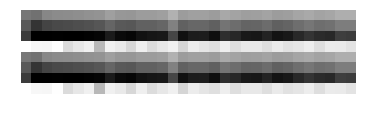

Class: 0 - Model's Output Class:


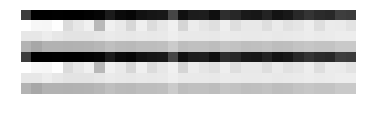

Class: 3 - Model's Output Class:


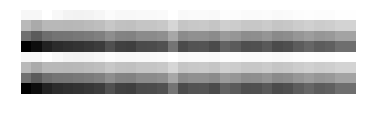

Class: 3 - Model's Output Class:


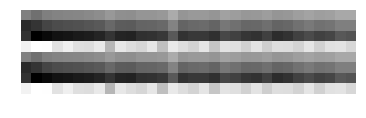

Class: 0 - Model's Output Class:


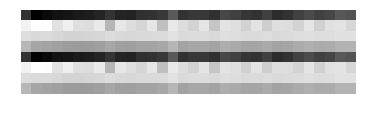

Class: 3 - Model's Output Class:


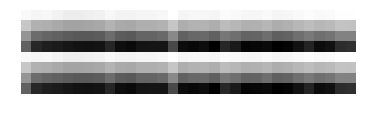

Class: 2 - Model's Output Class:


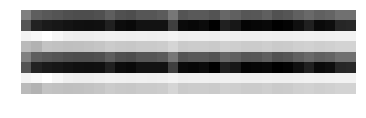

Class: 0 - Model's Output Class:


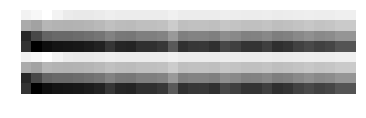

Class: 3 - Model's Output Class:


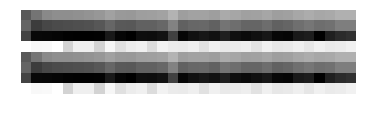

Class: 0 - Model's Output Class:


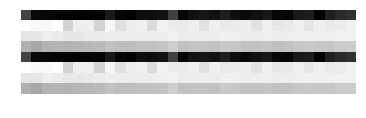

Class: 3 - Model's Output Class:


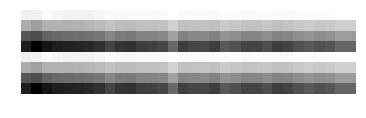

Class: 3 - Model's Output Class:


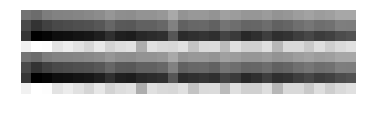

Class: 0 - Model's Output Class:


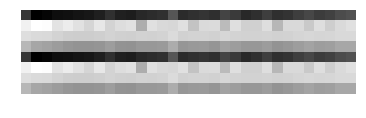

Class: 3 - Model's Output Class:


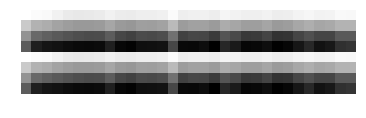

Class: 2 - Model's Output Class:


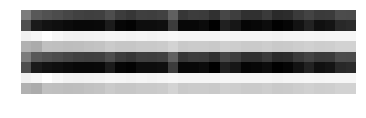

Class: 2 - Model's Output Class:


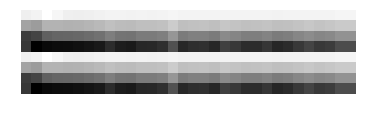

Class: 3 - Model's Output Class:


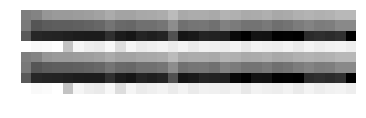

Class: 0 - Model's Output Class:


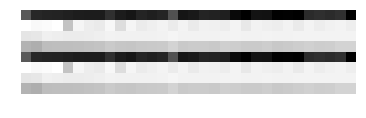

Class: 3 - Model's Output Class:


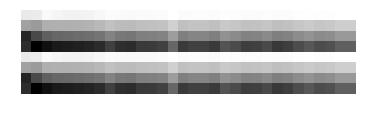

Class: 3 - Model's Output Class:


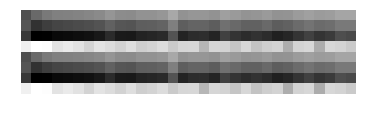

Class: 0 - Model's Output Class:


In [74]:
import matplotlib.pyplot as plt
#print('Loss:', loss)
print('Examples:')
for i in range(20):
    plt.imshow(xData[i].reshape(8,32), cmap='gray')
    plt.axis('off')
    plt.show()
    print('Class:', yyn[i], '- Model\'s Output Class:')

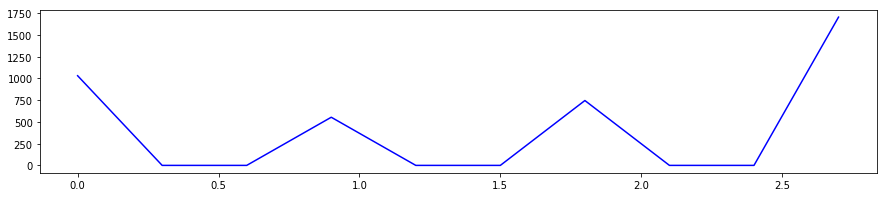

In [75]:
plt.figure(figsize=(15,3))

#fig, ax1 = plt.subplots()
values, base = np.histogram(yyn)
plt.plot(base[:-1], values, c='blue')

#ax2 = ax1.twinx()
#ax1.plot(test)

#plt.plot(yyn,color="red")
plt.show()